(<matplotlib.axes._subplots.AxesSubplot at 0x1c1c9c9d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x110365a20>)

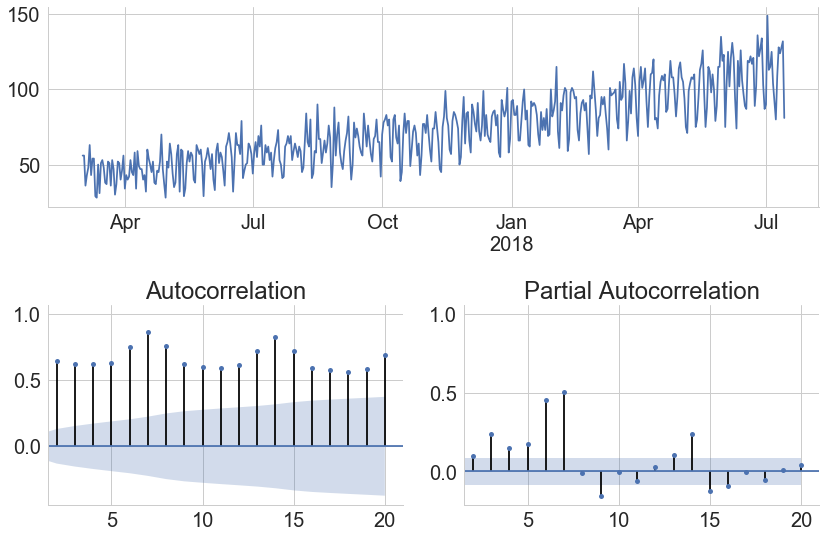

In [46]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.tsa.api as smt
from utils import poisson_process, plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook', palette='deep',
        font_scale=2, rc={'figure.figsize': [12, 8]})

λ = 200  
n = int(100000)  
t0 = pd.to_datetime('2017-03-01') 
freq = '1D'
thinning_components = [
    {'function': poisson_process._trend, 
     'params': {'percent_increase': 1.0, 'period': 365}},
    {'function': poisson_process._cyclical, 
     'params': {'weekday_factor': [1, 1, 1, 1, 1, 0.75, 0.75]}},
    {'function': poisson_process._seasonal, 
     'params': {'peak_time': '09:00:00', 'amplitude': 0.75}}]

nhpp = poisson_process.nhpp(λ, n, t0, freq, thinning_components)

plotting.tsplot(nhpp, lags=20)

### Testing for Stationarity

In [47]:
smt.adfuller(nhpp)

(0.080039993157162828,
 0.96467161170472027,
 13,
 486,
 {'1%': -3.4438771098680196,
  '10%': -2.5699473247641791,
  '5%': -2.8675053939390649},
 3536.1962785407686)

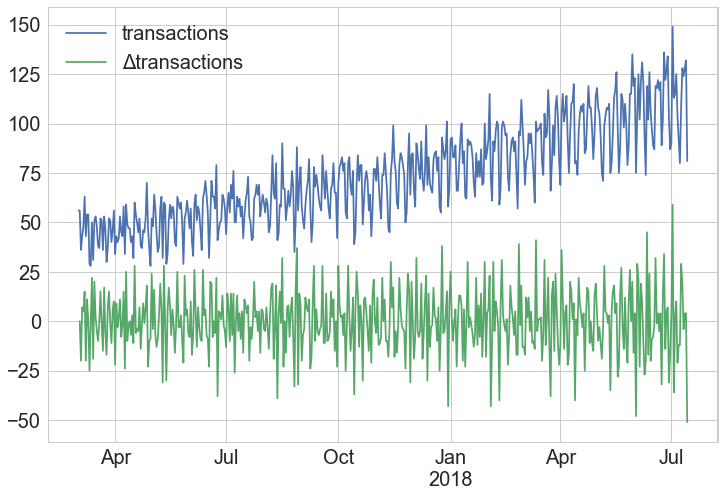

In [48]:
df_nhpp = (nhpp.to_frame()
               .assign(Δtransactions=lambda x: x['transactions'].diff())
               .assign(days_since_start=lambda x: (x.index - min(nhpp.index)).days))
df_nhpp[['transactions', 'Δtransactions']].plot()

In [49]:
smt.adfuller(df_nhpp['Δtransactions'].dropna())

(-13.12916714816844,
 1.5071508175273508e-24,
 12,
 486,
 {'1%': -3.4438771098680196,
  '10%': -2.5699473247641791,
  '5%': -2.8675053939390649},
 3527.8990116353343)

### Finding a Best-Fit SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                      transactions   No. Observations:                  500
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1754.102
Date:                           Sun, 03 Dec 2017   AIC                           3514.203
Time:                                   23:51:34   BIC                           3526.847
Sample:                               03-02-2017   HQIC                          3519.165
                                    - 07-14-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9788      0.011    -85.807      0.000      -1.001      -0.956
ma.S.L7       -0.8998      0.025    -36.079      0.000      -0.949      -0.851
sigma2        70.5607      4.181     16.877      0.000      62.366      78.755
===================================================================================
Ljung-Box (Q):                       29.35   Jarque-Bera (JB):                 4.83
Prob(Q):                              0.89   Prob(JB):                         0.09
Heteroskedasticity (H):               1.47   Skew:                             0.21
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

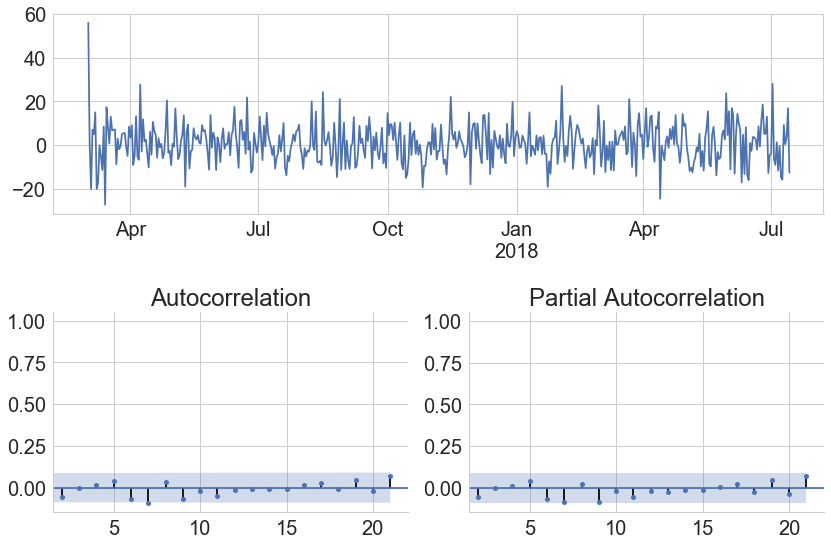

In [50]:
mod = smt.SARIMAX(nhpp, order=(0, 1, 1), seasonal_order=(0, 1, 1, 7))
res = mod.fit()
plotting.tsplot(res.resid, lags=21)
res.summary()

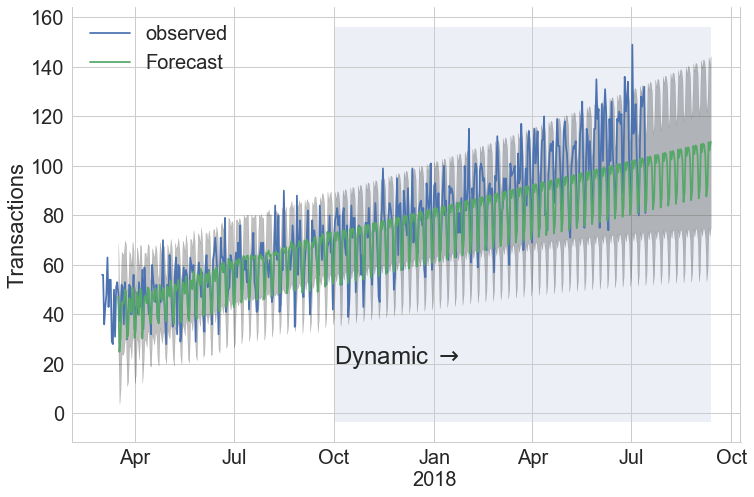

In [68]:
dynamic_start = '2017-10-01'

pred = res.get_prediction(start='2017-03-17', end=max(nhpp.index) + 60, dynamic=dynamic_start)
pred_ci = pred.conf_int()

ax = nhpp.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

# Highlight the forecast area
ax.fill_betweenx(ax.get_ylim(), pd.Timestamp(dynamic_start), pred.predicted_mean.index[-1],
                 alpha=.1, zorder=-1)
ax.annotate('Dynamic $\\rightarrow$', (pd.Timestamp(dynamic_start), 20))

ax.set_ylabel('Transactions')
plt.legend()
sns.despine()